<a href="https://colab.research.google.com/github/piaoruilin/yunbardillo/blob/main/Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving top-10_max_weeks.csv to top-10_max_weeks.csv
Saving top-10_with_genres_keywords.csv to top-10_with_genres_keywords.csv


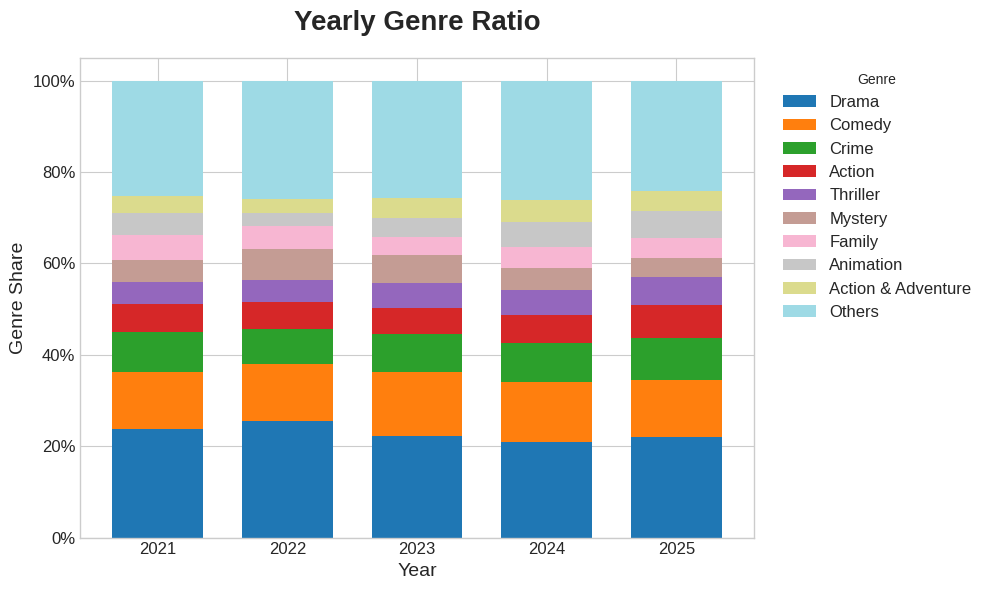

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 데이터 준비 ---
df = pd.read_csv('top-10_with_genres_keywords.csv')
df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year
df['genres'] = df['genres'].apply(ast.literal_eval)

# 각 영화/쇼를 장르별로 분리 (explode)
df_exploded = df.explode('genres')

# --- 2. 연도별 장르 비율 계산 ---
# 연도와 장르별로 등장 횟수를 계산합니다.
genre_counts = df_exploded.groupby(['year', 'genres']).size().reset_index(name='count')

# 피벗 테이블을 사용하여 데이터를 재구성합니다. (연도별로 장르의 등장 횟수)
pivot_df = genre_counts.pivot(index='year', columns='genres', values='count').fillna(0)

# 각 연도(행)의 합계로 나누어 비율을 계산합니다.
ratio_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# --- 3. 시각화를 위한 데이터 가공 ---
# 전체 기간 동안의 평균 비율을 기준으로 상위 9개 장르를 선정합니다.
top_genres = ratio_df.mean().nlargest(9).index

# 상위 9개 장르와 'Others'로 데이터를 재구성합니다.
df_plot = ratio_df[top_genres].copy()
df_plot['Others'] = 1 - df_plot.sum(axis=1) # 1(100%)에서 상위 장르 비율을 빼서 'Others'를 계산

# --- 4. 100% 누적 막대그래프 시각화 ---
plt.style.use('seaborn-v0_8-whitegrid')
# (수정) 그래프 크기를 (12, 7)로 줄입니다.
fig, ax = plt.subplots(figsize=(10, 6))

# 100% 누적 막대그래프를 그립니다.
df_plot.plot(kind='bar', stacked=True, ax=ax, width=0.7, cmap='tab20')

# (수정) 그래프의 제목과 축 이름을 영문으로 변경합니다.
ax.set_title('Yearly Genre Ratio', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Genre Share', fontsize=14)
ax.tick_params(axis='x', rotation=0) # x축 라벨을 수평으로 표시
ax.tick_params(axis='both', labelsize=12)

# Y축 레이블을 퍼센트(%) 형식으로 변경
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))

# (수정) 범례 제목을 영문으로 변경합니다.
ax.legend(title='Genre', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

In [8]:
# 1. 필요한 라이브러리 설치
!pip install mlxtend

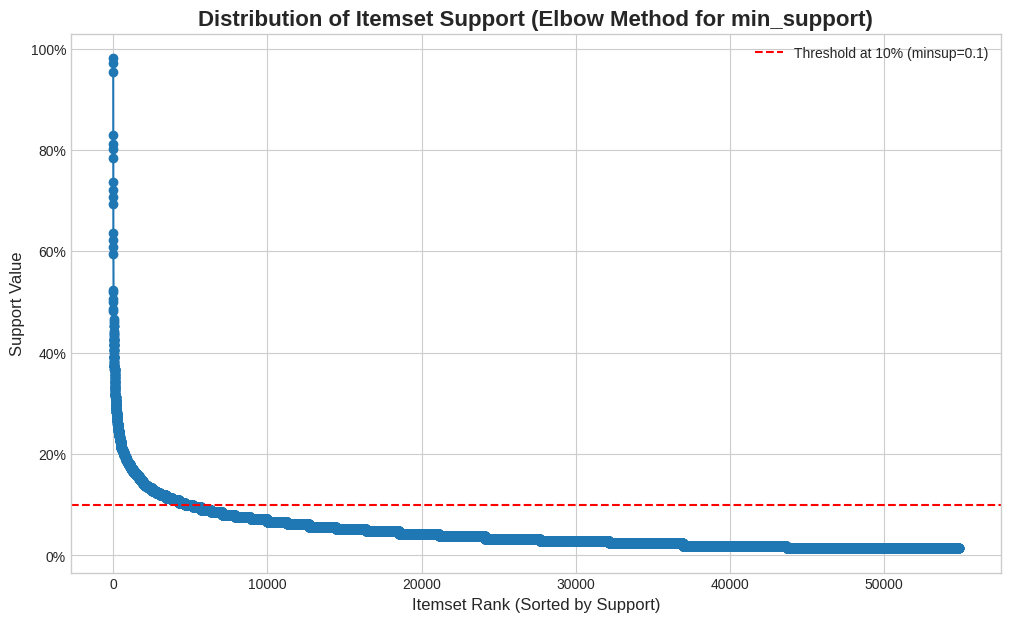

In [7]:
import pandas as pd
import ast
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 데이터 준비 ---
try:
    df = pd.read_csv('top-10_with_genres_keywords.csv')
except FileNotFoundError:
    print("데이터 파일을 찾을 수 없습니다: 'top-10_with_genres_keywords.csv'")
    exit()

df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year
df['genres'] = df['genres'].apply(ast.literal_eval)

# --- 2. 특정 연도(2023년)의 '주간 장바구니' 데이터 생성 ---
df_2023 = df[df['year'] == 2023]
transactions = df_2023.groupby(['week', 'category'])['genres'].apply(np.sum).tolist()
transactions = [list(set(item)) for item in transactions if item]

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

# --- 3. 낮은 min_support로 모든 조합의 지지도 계산 ---
# "최소 1% 이상 등장하는 모든 조합을 찾아줘" -> 가능한 많은 조합을 보기 위함
all_itemsets = apriori(df_onehot, min_support=0.01, use_colnames=True)

# 지지도가 높은 순으로 정렬
all_itemsets_sorted = all_itemsets.sort_values(by='support', ascending=False)
# 순위를 매기기 위한 'rank' 컬럼 추가
all_itemsets_sorted['rank'] = np.arange(len(all_itemsets_sorted))

# --- 4. 'Elbow Method' 그래프 시각화 ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(all_itemsets_sorted['rank'], all_itemsets_sorted['support'], marker='o', linestyle='-')

# 그래프 제목 및 레이블 설정
ax.set_title('Distribution of Itemset Support (Elbow Method for min_support)', fontsize=16, fontweight='bold')
ax.set_xlabel('Itemset Rank (Sorted by Support)', fontsize=12)
ax.set_ylabel('Support Value', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format)) # Y축을 퍼센트로 표시

# 기존에 사용했던 min_support=0.1(10%) 위치에 빨간 점선 추가
ax.axhline(y=0.1, color='r', linestyle='--', label='Threshold at 10% (minsup=0.1)')
ax.legend()

plt.grid(True)
plt.show()

In [27]:
# 1. 필요한 라이브러리 설치
import pandas as pd
import ast
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import numpy as np

# --- 2. 데이터 준비 ---
try:
    df = pd.read_csv('top-10_with_genres_keywords.csv')
except FileNotFoundError:
    print("파일을 찾을 수 없습니다: 'top-10_with_genres_keywords.csv'")
    raise

df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year
df['genres'] = df['genres'].apply(ast.literal_eval)

# --- 3. 전체 연도에 대해 반복 분석 ---
# 데이터에 있는 모든 연도를 가져와서 정렬
all_years = sorted(df['year'].unique())

for year in all_years:
    print(f"\n--- {year}년, 함께 등장한 빈도(지지도)가 15% 이상인 두 장르 조합(A&B) 목록 ---")

    # 해당 연도의 데이터만 필터링
    df_year = df[df['year'] == year]

    # '주간 장바구니' 데이터 생성
    transactions = df_year.groupby(['week', 'category'])['genres'].apply(np.sum).tolist()
    transactions = [list(set(item)) for item in transactions if item]

    if not transactions:
        print("해당 연도에 분석할 데이터가 충분하지 않습니다.")
        continue

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

    # Apriori로 지지도 10% 이상인 조합 찾기
    frequent_itemsets = apriori(df_onehot, min_support=0.15, use_colnames=True)

    # 결과 중에서 장르가 2개인 조합(A&B)만 필터링
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    results_df = frequent_itemsets[frequent_itemsets['length'] == 2]

    if results_df.empty:
        print("해당 연도에는 지지도 15% 이상인 두 장르 조합을 찾을 수 없습니다.")
    else:
        # 보기 좋게 정렬 및 컬럼 정리
        results_df_sorted = results_df.sort_values(by='support', ascending=False)
        results_df_sorted['itemsets'] = results_df_sorted['itemsets'].apply(lambda x: ' & '.join(list(x)))
        final_df = results_df_sorted[['itemsets', 'support']]

        print(final_df.to_string(index=False))


--- 2021년, 함께 등장한 빈도(지지도)가 15% 이상인 두 장르 조합(A&B) 목록 ---
                             itemsets  support
                       Comedy & Drama 0.942308
                        Drama & Crime 0.798077
                       Comedy & Crime 0.769231
                       Drama & Family 0.711538
                      Comedy & Family 0.701923
                    Animation & Drama 0.625000
                   Animation & Comedy 0.605769
                       Family & Crime 0.596154
                      Drama & Mystery 0.538462
                     Comedy & Mystery 0.509615
                    Animation & Crime 0.500000
                   Animation & Family 0.490385
                       Drama & Action 0.471154
                      Comedy & Action 0.461538
                      Mystery & Crime 0.461538
                      Drama & Romance 0.451923
                     Action & Romance 0.442308
                   Action & Adventure 0.442308
                     Comedy & Romance 0.442308
    

In [28]:
import pandas as pd
import ast
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import numpy as np

# --- 1. 데이터 준비 ---
try:
    df = pd.read_csv('top-10_with_genres_keywords.csv')
except FileNotFoundError:
    print("파일을 찾을 수 없습니다: 'top-10_with_genres_keywords.csv'")
    raise

df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year
# 문자열 리스트를 실제 리스트로 변환
df['genres'] = df['genres'].apply(ast.literal_eval)

# --- 2. 연도별 분석 결과를 저장할 리스트 생성 ---
all_results = []

# 데이터에 있는 모든 연도를 가져와서 정렬
all_years = sorted(df['year'].unique())

for year in all_years:
    # 해당 연도의 데이터만 필터링
    df_year = df[df['year'] == year]

    # '주간 장바구니' 데이터 생성
    transactions = df_year.groupby(['week', 'category'])['genres'].apply(np.sum).tolist()
    transactions = [list(set(item)) for item in transactions if item]

    if not transactions:
        continue

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

    # Apriori로 지지도 15% 이상인 조합 찾기
    frequent_itemsets = apriori(df_onehot, min_support=0.15, use_colnames=True)

    if not frequent_itemsets.empty:
        # 결과 중에서 장르가 2개인 조합만 필터링
        frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
        results_df = frequent_itemsets[frequent_itemsets['length'] == 2].copy() # .copy() to avoid SettingWithCopyWarning

        # 나중에 그룹화하기 위해 frozenset을 그대로 사용
        results_df['itemsets_str'] = results_df['itemsets'].apply(lambda x: ' & '.join(sorted(list(x))))
        results_df['year'] = year
        all_results.append(results_df[['year', 'itemsets_str', 'support']])

# --- 3. 우상향 조합 분석 ---
# 모든 연도의 결과를 하나의 데이터프레임으로 합치기
if not all_results:
    print("분석할 데이터가 충분하지 않습니다.")
else:
    trends_df = pd.concat(all_results, ignore_index=True)

    # 추세 분석을 위한 함수 정의 (선형 회귀 기울기 계산)
    def calculate_trend(series):
        # 최소 3년 이상 데이터가 있는 경우에만 추세 계산
        if len(series) < 3:
            return np.nan
        # 연도를 x, 지지도를 y로 놓고 기울기 계산
        x = series['year'].values
        y = series['support'].values
        # polyfit(x, y, 1)은 1차 다항식(직선)의 계수를 반환. [기울기, y절편]
        slope, _ = np.polyfit(x, y, 1)
        return slope

    # 장르 조합별로 그룹화하여 추세(기울기) 계산
    slopes = trends_df.groupby('itemsets_str').apply(calculate_trend)

    # 기울기가 양수인 '우상향' 조합만 필터링
    upward_trends = slopes[slopes > 0].sort_values(ascending=False).reset_index(name='trend_slope')

    # --- 4. 결과 출력 ---
    print("\n\n" + "="*60)
    print("📈 연도별 인기가 상승하는 '우상향' 트렌드 장르 조합")
    print("="*60)
    print("(최소 3년 이상, 지지도 15%를 넘은 기록이 있는 조합만 분석 대상)")

    if upward_trends.empty:
        print("\n분석 기간 동안 우상향하는 추세를 보이는 조합을 찾지 못했습니다.")
    else:
        # 각 조합의 연도별 지지도 정보를 함께 보여주기 위한 처리
        final_output = upward_trends.merge(
            trends_df.pivot(index='itemsets_str', columns='year', values='support'),
            on='itemsets_str'
        )
        # NaN 값은 해당 연도에 15%를 넘지 못했음을 의미
        final_output = final_output.fillna('-')

        print("\n'trend_slope'가 클수록 최근 인기가 더 가파르게 상승한 조합입니다.\n")
        print(final_output.to_string(index=False))



📈 연도별 인기가 상승하는 '우상향' 트렌드 장르 조합
(최소 3년 이상, 지지도 15%를 넘은 기록이 있는 조합만 분석 대상)

'trend_slope'가 클수록 최근 인기가 더 가파르게 상승한 조합입니다.

                         itemsets_str  trend_slope      2021      2022     2023     2024      2025
                  Crime & Documentary     0.041953  0.240385  0.307692 0.344340 0.471154  0.368421
                 Comedy & Documentary     0.041245  0.221154  0.341346 0.424528 0.485577  0.355263
                 Documentary & Family     0.040865         -  0.216346 0.198113 0.298077         -
                  Documentary & Drama     0.036184  0.259615  0.370192 0.424528 0.514423  0.368421
                Documentary & Mystery     0.035805  0.153846  0.197115 0.297170 0.336538  0.263158
                   Mystery & Thriller     0.026442         -  0.173077 0.306604 0.225962         -
                     Action & Mystery     0.021635         -  0.173077 0.297170 0.216346         -
                  Adventure & Mystery     0.021635         -  0.153846 0.207547 0.197115

<ipython-input-28-677e17433dff>:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes = trends_df.groupby('itemsets_str').apply(calculate_trend)


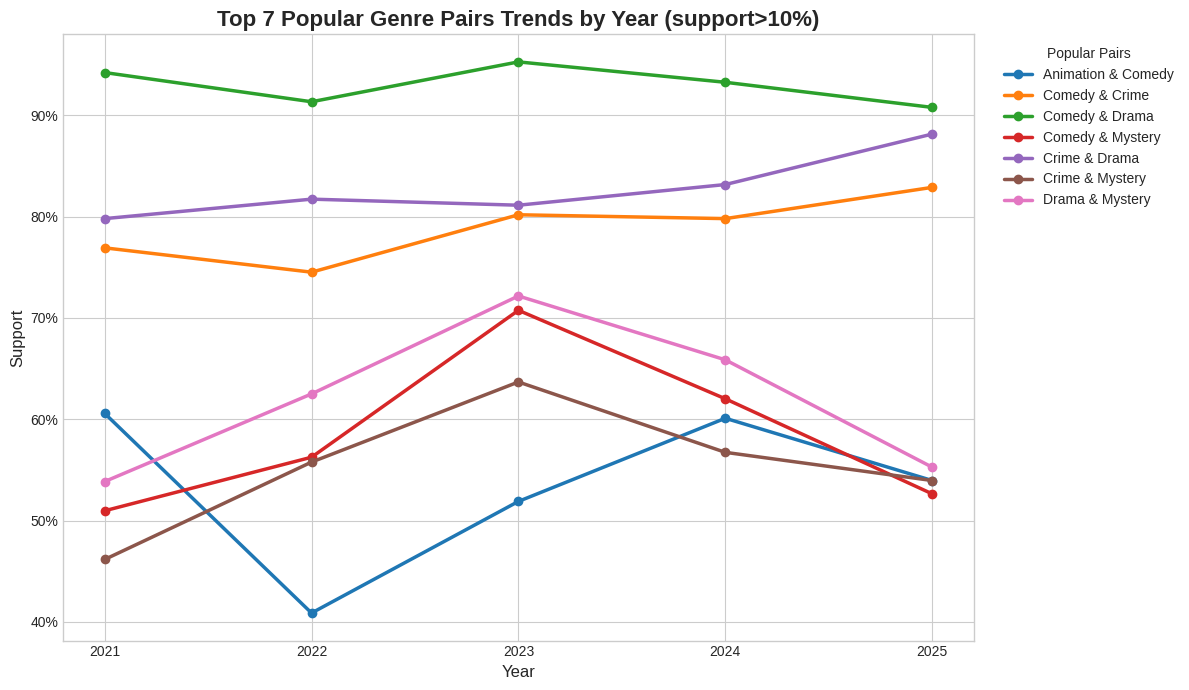

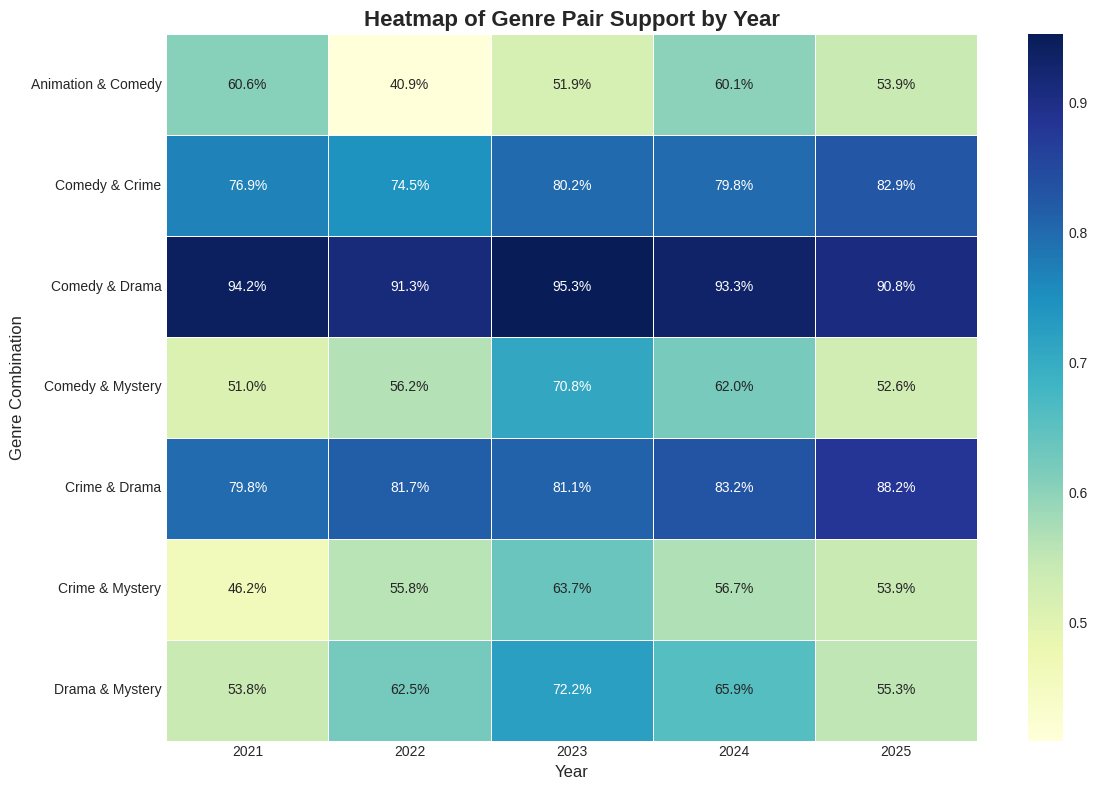

In [18]:
# 1. 필요한 라이브러리 설치
# !pip install mlxtend # 이미 설치하셨다면 주석 처리된 상태로 두시면 됩니다.

import pandas as pd
import ast
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 2. 데이터 준비 ---
try:
    df = pd.read_csv('top-10_with_genres_keywords.csv')
except FileNotFoundError:
    print("데이터 파일을 찾을 수 없습니다: 'top-10_with_genres_keywords.csv'")
    raise

df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year
df['genres'] = df['genres'].apply(ast.literal_eval)

# --- 3. 전체 연도에 대해 Apriori 분석 실행 ---
all_frequent_itemsets = []
all_years = sorted(df['year'].unique())

for year in all_years:
    df_year = df[df['year'] == year]
    transactions = df_year.groupby(['week', 'category'])['genres'].apply(np.sum).tolist()
    transactions = [list(set(item)) for item in transactions if item]

    if not transactions: continue

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

    # min_support=0.1 (10%)로 설정
    frequent_itemsets = apriori(df_onehot, min_support=0.1, use_colnames=True)

    if not frequent_itemsets.empty:
        frequent_itemsets['year'] = year
        all_frequent_itemsets.append(frequent_itemsets)

# --- 4. 시각화를 위한 데이터 가공 ---
if all_frequent_itemsets:
    trends_df = pd.concat(all_frequent_itemsets)
    trends_df['itemset_str'] = trends_df['itemsets'].apply(lambda x: ' & '.join(sorted(list(x))))
    trends_df_pairs = trends_df[trends_df['itemsets'].apply(len) == 2].copy()

    top_itemsets = trends_df_pairs.groupby('itemset_str')['support'].mean().nlargest(7).index
    plot_df = trends_df_pairs[trends_df_pairs['itemset_str'].isin(top_itemsets)]

    pivot_df = plot_df.pivot(index='year', columns='itemset_str', values='support')

    # --- 5. 시각화 1: 꺾은선 그래프 ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    pivot_df.plot(kind='line', marker='o', ax=ax, linewidth=2.5)

    ax.set_title('Top 7 Popular Genre Pairs Trends by Year (support>10%)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Support', fontsize=12)
    ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    ax.legend(title='Popular Pairs', bbox_to_anchor=(1.02, 1), loc='upper left')

    # --- X축 눈금 수정 ---
    # pivot_df의 인덱스(연도)를 X축의 눈금으로 강제하여 정수 연도만 표시합니다.
    ax.set_xticks(pivot_df.index)

    plt.tight_layout()
    plt.show()

    # --- 6. 시각화 2: 히트맵 ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(pivot_df.T, annot=True, fmt=".1%", cmap="YlGnBu", linewidths=.5, ax=ax)

    ax.set_title('Heatmap of Genre Pair Support by Year', fontsize=16, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Genre Combination', fontsize=12)
    plt.tight_layout()
    plt.show()

else:
    print("분석할 데이터가 없습니다.")

In [26]:
import pandas as pd

# 데이터셋을 불러옵니다.
# Colab 환경에서 이 코드를 실행하기 전에,
# 'top-10_with_genres_keywords.csv' 파일을 Colab 세션에 업로드해야 합니다.
try:
    df = pd.read_csv('top-10_with_genres_keywords.csv')
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 'top-10_with_genres_keywords.csv' 파일을 Colab에 업로드했는지 확인해주세요.")
    # You might want to exit or handle this case differently
    exit()


# 'week' 컬럼을 날짜 형식으로 변환합니다.
df['week'] = pd.to_datetime(df['week'])

# 2023년 데이터만 필터링합니다.
df_2023 = df[df['week'].dt.year == 2023].copy()

# 장르 조합을 확인하는 함수입니다.
def has_genres(genres_str, required_genres):
    """genres_str에 required_genres의 모든 장르가 포함되어 있는지 확인합니다."""
    genres = genres_str.strip("[]").replace("'", "").split(', ')
    return all(genre in genres for genre in required_genres)

# --- 장르: 미스터리 & 코미디 ---
mystery_comedy_df = df_2023[df_2023['genres'].apply(lambda x: has_genres(x, ['Mystery', 'Comedy']))]
mystery_comedy_agg = mystery_comedy_df.groupby('show_title').agg(
    total_weekly_hours_viewed=('weekly_hours_viewed', 'sum'),
    max_cumulative_weeks_in_top_10=('cumulative_weeks_in_top_10', 'max')
).reset_index().sort_values(by='total_weekly_hours_viewed', ascending=False)


# --- 장르: 미스터리 & 드라마 ---
mystery_drama_df = df_2023[df_2023['genres'].apply(lambda x: has_genres(x, ['Mystery', 'Drama']))]
mystery_drama_agg = mystery_drama_df.groupby('show_title').agg(
    total_weekly_hours_viewed=('weekly_hours_viewed', 'sum'),
    max_cumulative_weeks_in_top_10=('cumulative_weeks_in_top_10', 'max')
).reset_index().sort_values(by='total_weekly_hours_viewed', ascending=False)

# --- 장르: 미스터리 & 범죄 ---
mystery_crime_df = df_2023[df_2023['genres'].apply(lambda x: has_genres(x, ['Mystery', 'Crime']))]
mystery_crime_agg = mystery_crime_df.groupby('show_title').agg(
    total_weekly_hours_viewed=('weekly_hours_viewed', 'sum'),
    max_cumulative_weeks_in_top_10=('cumulative_weeks_in_top_10', 'max')
).reset_index().sort_values(by='total_weekly_hours_viewed', ascending=False)


# 결과를 출력합니다.
print("--- 2023년 미스터리 & 코미디 작품 ---")
print(mystery_comedy_agg.to_string())
print("\n" + "="*50 + "\n")

print("--- 2023년 미스터리 & 드라마 작품 ---")
print(mystery_drama_agg.to_string())
print("\n" + "="*50 + "\n")

print("--- 2023년 미스터리 & 범죄 작품 ---")
print(mystery_crime_agg.to_string())

--- 2023년 미스터리 & 코미디 작품 ---
                           show_title  total_weekly_hours_viewed  max_cumulative_weeks_in_top_10
16                          Wednesday                  492160000                              20
7   Glass Onion: A Knives Out Mystery                  219590000                               7
13                   Murder Mystery 2                  155730000                               5
11                          Mask Girl                  105600000                               4
12                     Murder Mystery                   58120000                               4
5                         Florida Man                   55690000                               2
4                   Behind Your Touch                   46000000                               4
15                 They Cloned Tyrone                   43600000                               3
9                          Knives Out                   24230000                               2
14

In [12]:
import pandas as pd
import ast
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np

# --- 2. 데이터 준비 ---
try:
    df = pd.read_csv('top-10_with_genres_keywords.csv')
except FileNotFoundError:
    print("데이터 파일을 찾을 수 없습니다: 'top-10_with_genres_keywords.csv'")
    raise

df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year
df['genres'] = df['genres'].apply(ast.literal_eval)

# --- 3. 특정 연도(2023년)의 '주간 장바구니' 데이터 생성 ---
df_2023 = df[df['year'] == 2023]
transactions = df_2023.groupby(['week', 'category'])['genres'].apply(np.sum).tolist()
transactions = [list(set(item)) for item in transactions if item]

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

# --- 4. Apriori 알고리즘으로 빈번한 조합 찾기 ---
# minsup을 15%로 설정하여 의미있는 조합을 먼저 찾습니다.
frequent_itemsets = apriori(df_onehot, min_support=0.15, use_colnames=True)

# --- 5. 연관 규칙(Association Rules) 생성 ---
# 찾은 조합을 바탕으로 "A가 나타났을 때 B가 나타난다"는 규칙을 만듭니다.
# confidence(신뢰도)가 50% 이상인 규칙만 의미있다고 가정합니다.
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)


# --- 6. '드라마'를 기준으로 한 결과 필터링 및 출력 ---
# antecedent(조건)에 'Drama'만 포함된 규칙을 찾습니다.
rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
drama_rules = rules[(rules['antecedent_len'] == 1) & (rules['antecedents'].astype(str).str.contains("'Drama'"))]

# 신뢰도(confidence)가 높은 순으로 정렬
drama_rules_sorted = drama_rules.sort_values(by='confidence', ascending=False)


print("--- 2023년, '드라마'를 봤을 때 다른 장르가 함께 나타날 확률 (신뢰도 순) ---")
# 보기 좋게 컬럼 정리
result_df = drama_rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
# frozenset 형태를 보기 쉽게 문자열로 변환
result_df = result_df.copy()
result_df['antecedents'] = result_df['antecedents'].apply(list).astype(str)
result_df['consequents'] = result_df['consequents'].apply(list).astype(str)

print(result_df.to_string(index=False))

print("\n--- 용어 설명 ---")
print("• antecedents: 조건이 되는 장르 (A)")
print("• consequents: 결과가 되는 장르 (B)")
print("• support: A와 B가 함께 나타난 주의 비율")
print("• confidence: A가 나타난 주 중에서 B도 함께 나타난 주의 비율 (A→B의 확률)")
print("• lift: 그냥 B가 나타날 확률 대비 A가 나타났을 때 B가 나타날 확률. (1보다 크면 강한 연관성)")

--- 2023년, '드라마'를 봤을 때 다른 장르가 함께 나타날 확률 (신뢰도 순) ---
antecedents                    consequents  support  confidence     lift
  ['Drama']                     ['Comedy'] 0.952830    0.971154 0.999440
  ['Drama']                      ['Crime'] 0.811321    0.826923 0.996066
  ['Drama']            ['Comedy', 'Crime'] 0.783019    0.798077 0.995249
  ['Drama']                    ['Mystery'] 0.721698    0.735577 0.999630
  ['Drama']          ['Comedy', 'Mystery'] 0.693396    0.706731 0.998846
  ['Drama']           ['Mystery', 'Crime'] 0.622642    0.634615 0.996581
  ['Drama'] ['Comedy', 'Mystery', 'Crime'] 0.594340    0.605769 0.995528
  ['Drama']                  ['Animation'] 0.504717    0.514423 0.982502
  ['Drama']        ['Animation', 'Comedy'] 0.500000    0.509615 0.982168

--- 용어 설명 ---
• antecedents: 조건이 되는 장르 (A)
• consequents: 결과가 되는 장르 (B)
• support: A와 B가 함께 나타난 주의 비율
• confidence: A가 나타난 주 중에서 B도 함께 나타난 주의 비율 (A→B의 확률)
• lift: 그냥 B가 나타날 확률 대비 A가 나타났을 때 B가 나타날 확률. (1보다 크면 강한 연관성)


In [4]:
import pandas as pd
import ast

# --- 1. 데이터 불러오기 ---
# Colab 왼편의 파일 아이콘을 클릭하여 'top-10_with_genres_keywords.csv' 파일을 업로드해주세요.
try:
    df = pd.read_csv('top-10_with_genres_keywords.csv')
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 'top-10_with_genres_keywords.csv' 파일을 Colab에 업로드했는지 확인해주세요.")
    raise

# --- 2. 데이터 전처리 ---
# 날짜 형식 변환 및 연도 추출
df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year
# 문자열 형태의 리스트를 실제 파이썬 리스트로 변환
df['genres'] = df['genres'].apply(ast.literal_eval)

# --- 3. 데이터 필터링 ---
# 검색할 장르들을 set으로 정의 (검색 속도 향상)
required_genres = {'Comedy', 'Mystery', 'Drama'}

# 2023년 데이터만 먼저 필터링
df_2023 = df[df['year'] == 2023].copy()

# 장르 리스트에 required_genres의 모든 요소가 포함되어 있는지 확인하는 함수
def contains_all_genres(genre_list):
    # 각 작품의 장르 리스트를 set으로 변환하여, required_genres가 부분집합인지 확인
    return required_genres.issubset(set(genre_list))

# 위 함수를 적용하여 최종적으로 원하는 작품이 포함된 행을 필터링
final_filtered_df = df_2023[df_2023['genres'].apply(contains_all_genres)]

# --- 4. 결과 추출 및 출력 ---
# 필터링된 결과에서 중복을 제외한 작품 제목만 추출
unique_shows = final_filtered_df['show_title'].unique()

print("--- 2023년 '코미디', '미스터리', '드라마' 장르를 모두 포함한 작품 목록 ---")
if len(unique_shows) > 0:
    for show in unique_shows:
        print(f"• {show}")
else:
    print("해당 조건을 모두 만족하는 작품을 찾을 수 없습니다.")

--- 2023년 '코미디', '미스터리', '드라마' 장르를 모두 포함한 작품 목록 ---
• Behind Your Touch
• Mask Girl
• 6ixtynin9 The Series
• Florida Man
• Freeridge


In [6]:
import pandas as pd
import ast

# --- 1. 데이터 불러오기 및 전처리 ---
try:
    df = pd.read_csv('top-10_with_genres_keywords.csv')
except FileNotFoundError:
    print("데이터 파일을 찾을 수 없습니다: 'top-10_with_genres_keywords.csv'")
    exit()

df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year
df['genres'] = df['genres'].apply(ast.literal_eval)

# --- 2. 작품 탐색: 2023년 & 3가지 장르 모두 포함 ---
required_genres = {'Comedy', 'Mystery', 'Drama'}
df_2023 = df[df['year'] == 2023].copy()

def contains_all_genres(genre_list):
    return required_genres.issubset(set(genre_list))

filtered_df = df_2023[df_2023['genres'].apply(contains_all_genres)]
found_shows = filtered_df['show_title'].unique().tolist()

# --- 3. 조건에 따른 결과 분석 및 출력 ---
print("--- 2023년 '코미디 & 미스터리 & 드라마' 작품 분석 결과 ---")

if len(found_shows) > 0:
    print(f"\n요청하신 조건에 맞는 작품을 찾았습니다: {found_shows}")

    # 찾은 작품들의 데이터만 필터링
    analysis_df = df_2023[df_2023['show_title'].isin(found_shows)]

    # 작품별 데이터 집계
    grouped = analysis_df.groupby('show_title')

    result = grouped.agg(
        total_weekly_views=('weekly_views', 'sum'),
        max_cumulative_weeks=('cumulative_weeks_in_top_10', 'max')
    )

    # 컬럼명 변경 및 정렬
    result.rename(columns={
        'total_weekly_views': '총 누적 시청 수 (Total Views)',
        'max_cumulative_weeks': 'TOP 10 최대 유지 기간 (Weeks)'
    }, inplace=True)

    result_sorted = result.sort_values(by='총 누적 시청 수 (Total Views)', ascending=False)

    print("\n[작품별 누적 시청 수 및 TOP 10 최대 유지 기간]")
    print(result_sorted.to_string())

else:
    print("\n데이터를 재검색했으나, 2023년에 세 가지 장르를 모두 포함하는 작품을 찾을 수 없었습니다.")
    print("분석을 원하시는 특정 작품명이 있다면 알려주세요.")

--- 2023년 '코미디 & 미스터리 & 드라마' 작품 분석 결과 ---

요청하신 조건에 맞는 작품을 찾았습니다: ['Behind Your Touch', 'Mask Girl', '6ixtynin9 The Series', 'Florida Man', 'Freeridge']

[작품별 누적 시청 수 및 TOP 10 최대 유지 기간]
                      총 누적 시청 수 (Total Views)  TOP 10 최대 유지 기간 (Weeks)
show_title                                                            
Mask Girl                            15400000                        4
Behind Your Touch                     6500000                        4
6ixtynin9 The Series                  1400000                        1
Florida Man                                 0                        2
Freeridge                                   0                        1


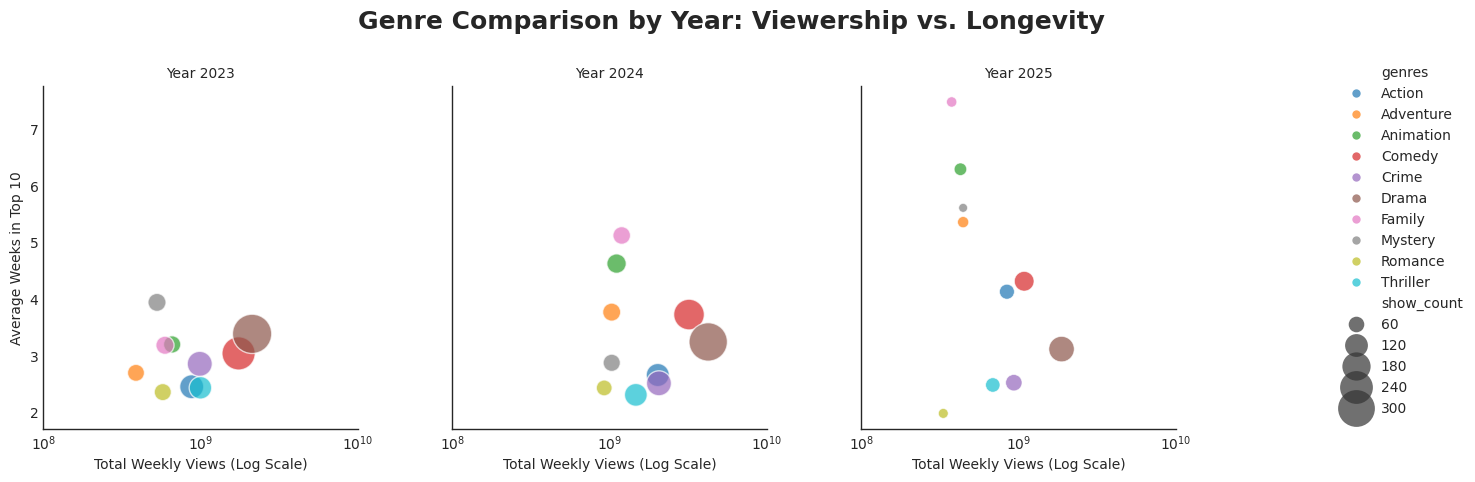

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. 데이터 준비 ---
df = pd.read_csv('top-10_with_genres_keywords.csv')
df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year
df['genres'] = df['genres'].apply(ast.literal_eval)

df_exploded = df.explode('genres')

# --- 2. 연도별/장르별 데이터 집계 ---
genre_yearly_stats = df_exploded.groupby(['year', 'genres']).agg(
    total_weekly_views=('weekly_views', 'sum'),
    avg_cumulative_weeks=('cumulative_weeks_in_top_10', 'mean'),
    show_count=('show_title', 'nunique')
).reset_index()

# 시각화할 상위 10개 장르 선정
top_genres_by_views = genre_yearly_stats.groupby('genres')['total_weekly_views'].sum().nlargest(10).index
analysis_df = genre_yearly_stats[genre_yearly_stats['genres'].isin(top_genres_by_views)]

# 2021년과 2022년 데이터 제외
analysis_df = analysis_df[~analysis_df['year'].isin([2021, 2022])]


# --- 3. 최종 그래프 시각화 ---
sns.set_style("white")

g = sns.relplot(
    data=analysis_df,
    x="total_weekly_views",
    y="avg_cumulative_weeks",
    col="year",
    hue="genres",
    size="show_count",
    sizes=(40, 800),
    alpha=0.7,
    kind="scatter",
    col_wrap=3,
    height=4.5,
    aspect=1
)

# --- 4. 그래프 기본 정보 설정 ---
g.set(xscale="log")
g.set_titles("Year {col_name}")
g.fig.suptitle('Genre Comparison by Year: Viewership vs. Longevity', fontsize=18, y=1.05, fontweight='bold')


# 상세 X축 눈금 설정
tick_values = [10**8, 10**9, 10**10]
tick_labels = ['$10^8$', '$10^9$', '$10^{10}$']

for ax in g.axes.flat:
    if not ax.has_data():
        continue
    ax.set_xticks(tick_values)
    ax.set_xticklabels(tick_labels)

# --- 5. 모든 그래프에 축 주석 추가 (수정된 부분) ---
# 기존의 g.set_axis_labels() 대신, 반복문으로 각 그래프에 축 이름을 직접 설정합니다.
for ax in g.axes.flat:
    if not ax.has_data():
        continue
    ax.set_xlabel("Total Weekly Views (Log Scale)", fontsize=10)
    ax.set_ylabel("Average Weeks in Top 10", fontsize=10)


# --- 6. 최종 레이아웃 조정 ---
g.fig.subplots_adjust(top=0.88, right=0.8, hspace=0.4, wspace=0.3)

plt.show()

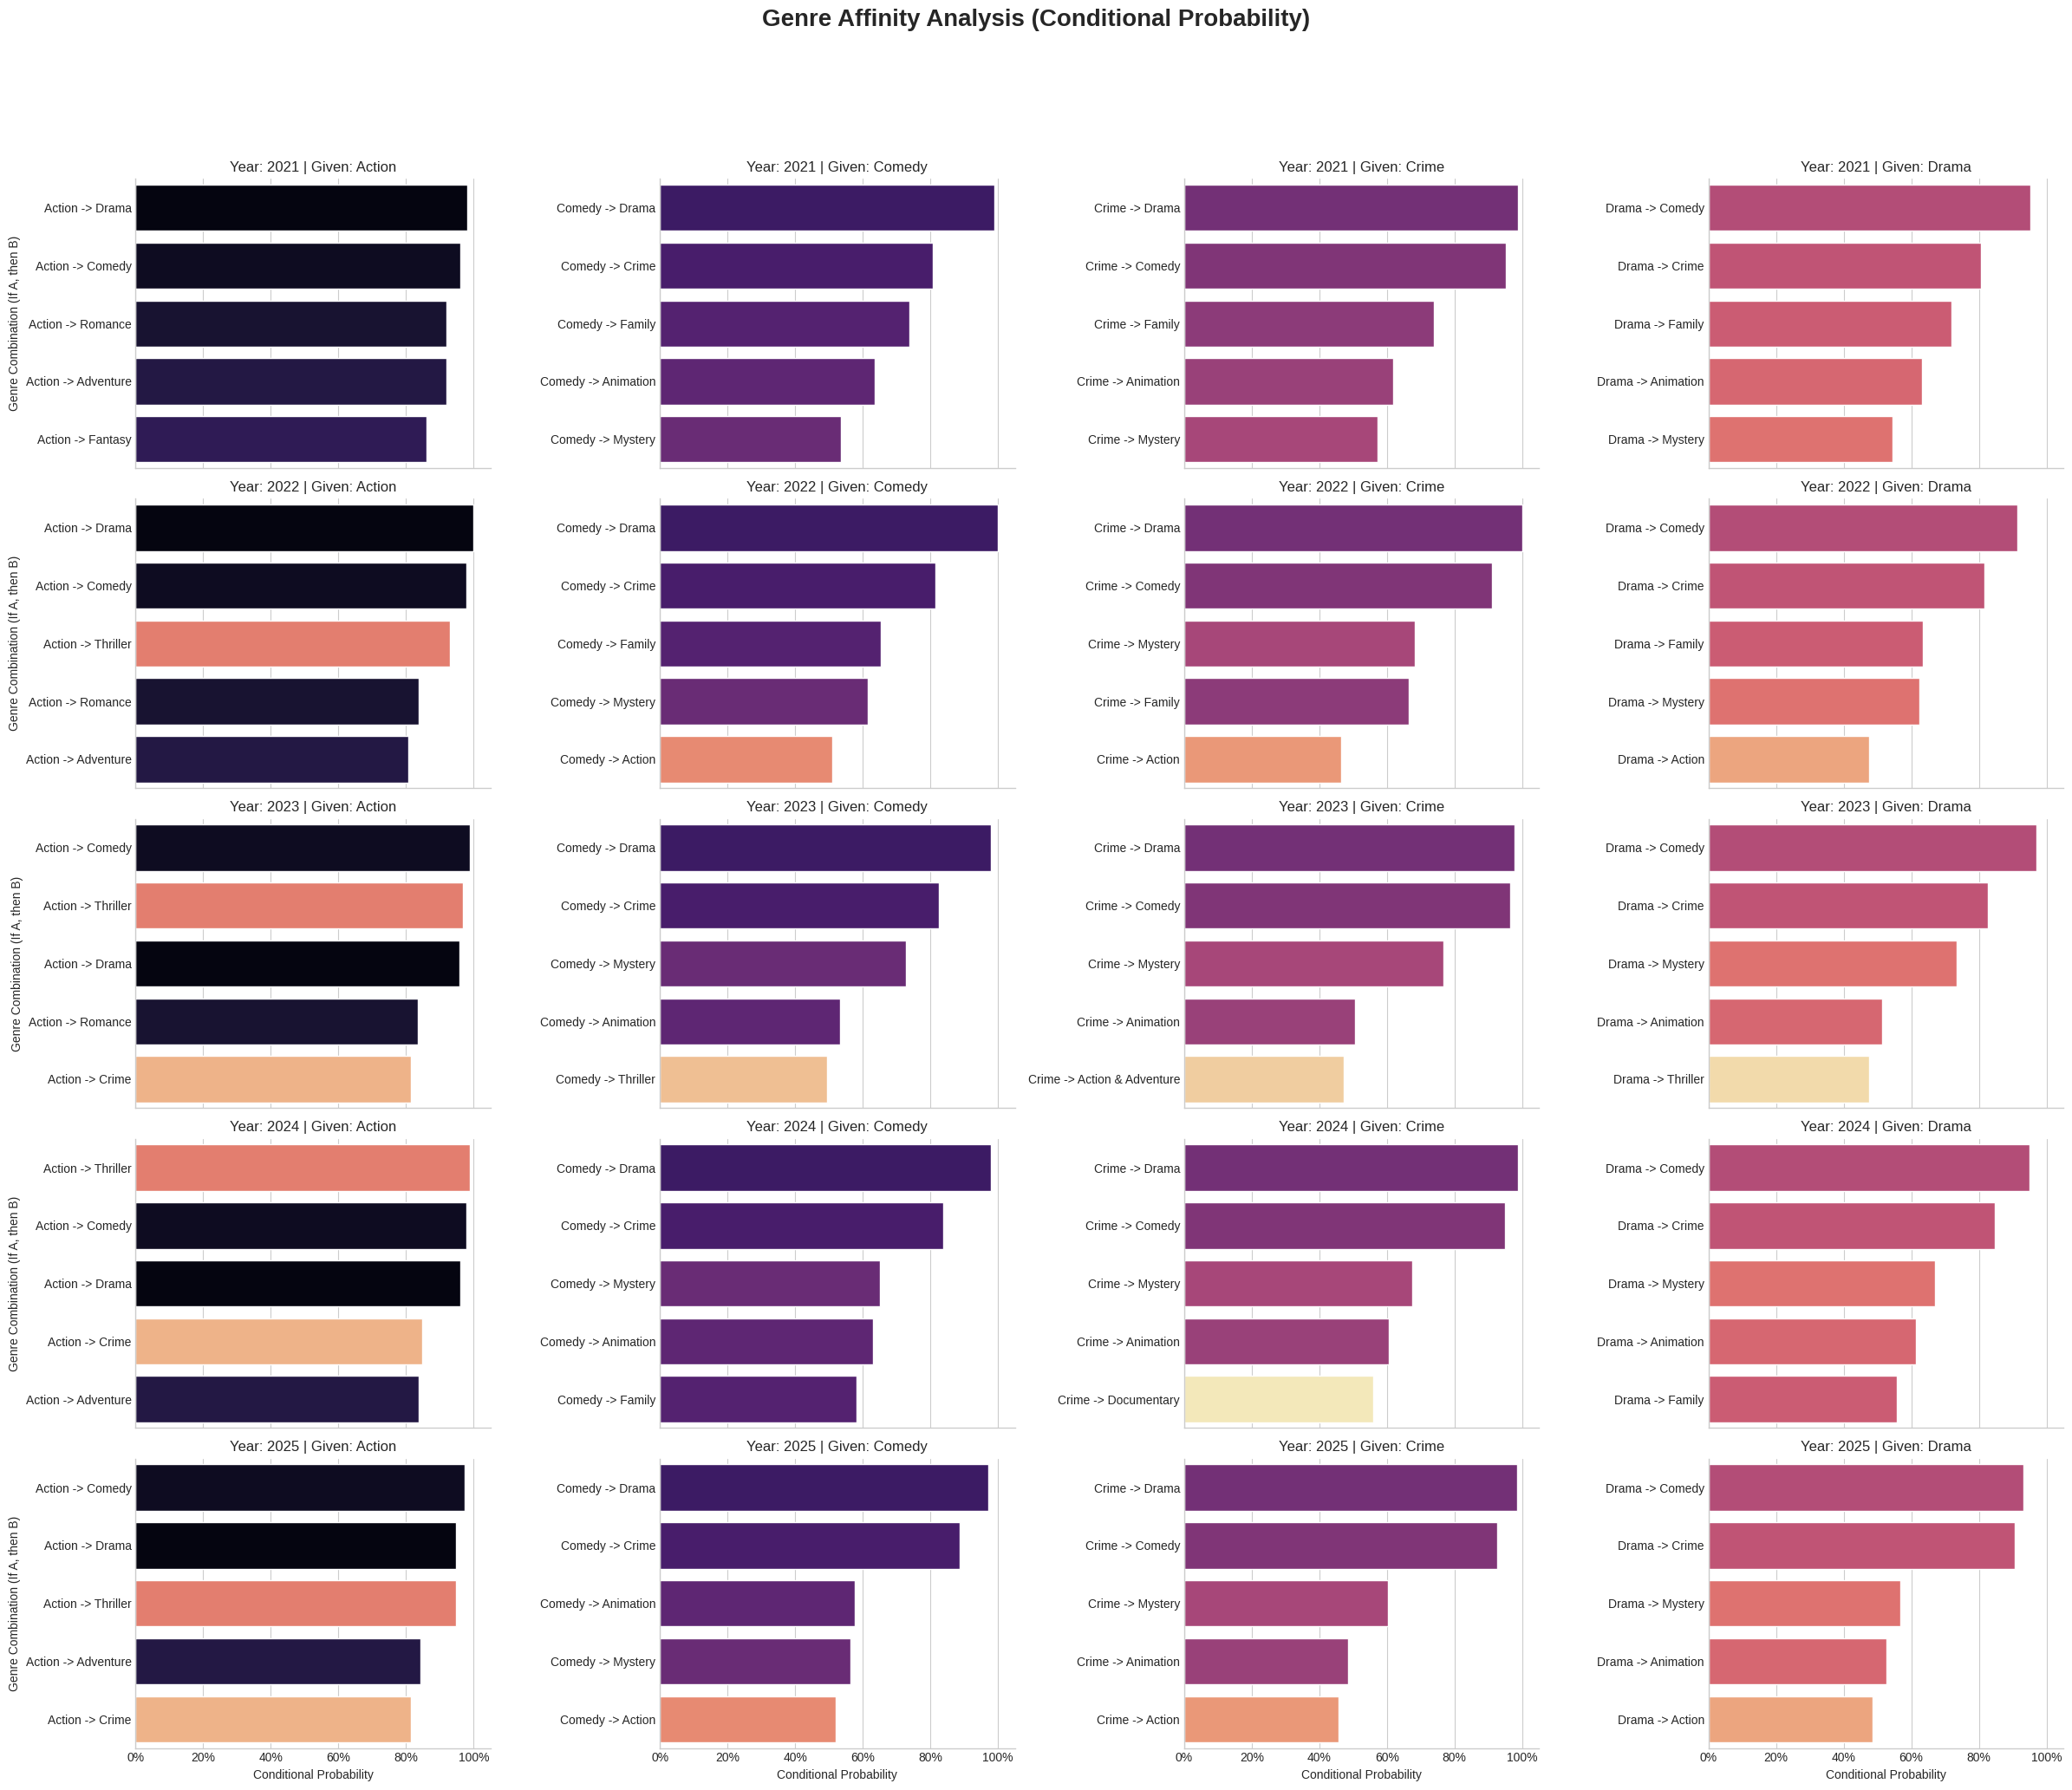

In [ ]:
  import pandas as pd
  import ast
  from itertools import permutations
  from collections import defaultdict
  import seaborn as sns
  import matplotlib.pyplot as plt
  import numpy as np # np.sum을 사용하기 위해 import

  # --- 1. 데이터 준비 ---
  df = pd.read_csv('top-10_with_genres_keywords.csv')
  df['week'] = pd.to_datetime(df['week'])
  df['year'] = df['week'].dt.year
  df['genres'] = df['genres'].apply(ast.literal_eval)


  # --- 2. 연도별 조건부 확률 계산 ---
  all_conditional_probs = []
  analysis_years = sorted(df['year'].unique())

  for year in analysis_years:
      df_year = df[df['year'] == year]

      # (수정 1) apply(sum) 대신 np.sum 사용
      transactions = df_year.groupby(['week', 'category'])['genres'].apply(np.sum).tolist()
      transactions = [list(set(item)) for item in transactions if item]

      if not transactions:
          continue

      genre_counts = defaultdict(int)
      pair_counts = defaultdict(int)

      for transaction in transactions:
          for genre in transaction:
              genre_counts[genre] += 1
          for g1, g2 in permutations(transaction, 2):
              pair_counts[(g1, g2)] += 1

      for (genre_A, genre_B), count_AB in pair_counts.items():
          count_A = genre_counts[genre_A]
          if count_A > 0:
              cond_prob = count_AB / count_A
              all_conditional_probs.append({
                  'year': year,
                  'Given_Genre': genre_A,
                  'Result_Genre': genre_B,
                  'prob': cond_prob
              })

  prob_df = pd.DataFrame(all_conditional_probs)


  # --- 3. 시각화를 위한 데이터 가공 ---
  focus_genres = ['Drama', 'Comedy', 'Crime', 'Action']
  prob_filtered = prob_df[prob_df['Given_Genre'].isin(focus_genres)]

  # (수정 2) DeprecationWarning을 해결하기 위해 더 현대적인 방식으로 코드를 수정
  top5_df = prob_filtered.sort_values(['year', 'Given_Genre', 'prob'], ascending=[True, True, False]) \
                        .groupby(['year', 'Given_Genre']) \
                        .head(5)

  top5_df['label'] = top5_df.apply(lambda row: f"{row['Given_Genre']} -> {row['Result_Genre']}", axis=1)


  # --- 4. 최종 결과 시각화 ---
  # (수정 3) hue='label' 및 legend=False 추가
  g = sns.catplot(
      data=top5_df,
      x='prob',
      y='label',
      hue='label',       # y축 변수를 hue로 지정
      col='Given_Genre',
      row='year',
      kind='bar',
      height=4,
      aspect=1.5,
      sharey=False,
      palette='magma',
      legend=False     # hue를 사용했으므로 범례는 숨김
  )

  # 그래프 제목 및 레이블 설정
  g.fig.suptitle('Genre Affinity Analysis (Conditional Probability)', fontsize=20, y=1.03, fontweight='bold')
  g.set_axis_labels('Conditional Probability', 'Genre Combination (If A, then B)')
  g.set_titles("Year: {row_name} | Given: {col_name}", size=12)

  # x축 레이블을 퍼센트(%) 형식으로 변경
  for ax in g.axes.flat:
      ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))

  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.show()

<ipython-input-3-aeb03ab427e5>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(top_genres))
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vzju8i2/48q5r20y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vzju8i2/90d33cby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77119', 'data', 'file=/tmp/tmp1vzju8i2/48q5r20y.json', 'init=/tmp/tmp1vzju8i2/90d33cby.json', 'output', 'file=/tmp/tmp1vzju8i2/prophet_modelpocdws24/prophet_model-20250527121936.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:19:36 - cmdstanpy - INFO - Chain [1] start processing


상위 9개 장르에 대한 미래 점유율 예측을 시작합니다...
분석 대상 장르: ['Drama', 'Comedy', 'Crime', 'Action', 'Thriller', 'Mystery', 'Family', 'Animation', 'Action & Adventure']


INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vzju8i2/21yrb1o_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vzju8i2/hum8xbj8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42111', 'data', 'file=/tmp/tmp1vzju8i2/21yrb1o_.json', 'init=/tmp/tmp1vzju8i2/hum8xbj8.json', 'output', 'file=/tmp/tmp1vzju8i2/prophet_modelbrb6a87z/prophet_model-20250527121936.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:19:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:19:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vzju8i2/isuduq8n.json
DEBUG:cmdstanpy:input tempfile


예측이 완료되었습니다.


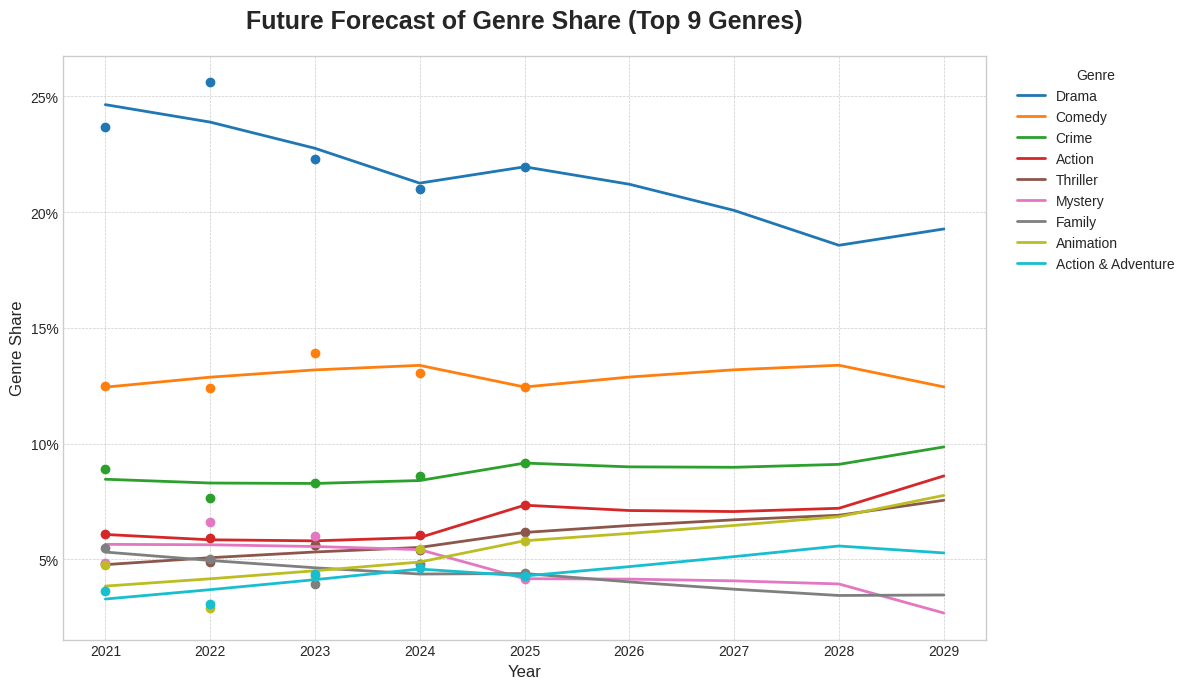


--- 향후 4년간 장르별 예상 점유율 (%) ---
      Drama  Comedy  Crime  Action  Thriller  Mystery  Family  Animation  Action & Adventure
ds                                                                                          
2026 21.21%  12.88%  9.00%   7.11%     6.46%    4.15%   4.03%      6.12%               4.69%
2027 20.08%  13.19%  8.98%   7.07%     6.71%    4.07%   3.71%      6.47%               5.12%
2028 18.57%  13.39%  9.11%   7.21%     6.91%    3.94%   3.44%      6.85%               5.58%
2029 19.28%  12.45%  9.86%   8.61%     7.56%    2.68%   3.46%      7.77%               5.28%


In [ ]:
# 1. Prophet 등 필요한 라이브러리 설치
!pip install prophet pandas matplotlib

import pandas as pd
import ast
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # 색상 지정을 위해 import
import numpy as np

# --- 2. 데이터 준비 (연도별 장르 비율 계산) ---
# Colab 왼편의 파일 아이콘을 클릭하여 'top-10_with_genres_keywords.csv' 파일을 업로드해주세요.
try:
    df = pd.read_csv('top-10_with_genres_keywords.csv')
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 'top-10_with_genres_keywords.csv' 파일을 Colab에 업로드했는지 확인해주세요.")
    raise

df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year

# 문자열로 된 리스트를 실제 리스트로 변환
df['genres'] = df['genres'].apply(ast.literal_eval)

# 각 영화/쇼를 장르별로 분리 (explode)
df_exploded = df.explode('genres')

# 연도와 장르별로 등장 횟수를 계산
genre_counts = df_exploded.groupby(['year', 'genres']).size().reset_index(name='count')

# 피벗 테이블을 사용하여 데이터를 재구성 (연도별 장르 등장 횟수)
pivot_df = genre_counts.pivot(index='year', columns='genres', values='count').fillna(0)

# 각 연도(행)의 합계로 나누어 비율을 계산
ratio_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Prophet을 위해 날짜 형식으로 인덱스 변환 ('2021' -> '2021-01-01')
ratio_df.index = pd.to_datetime(ratio_df.index.astype(str) + '-01-01')

# --- 3. 전체 장르에 대한 미래 예측 실행 ---
# 전체 기간 동안의 평균 비율을 기준으로 상위 9개 장르를 선정
top_genres = ratio_df.mean().nlargest(9).index.tolist()

# 예측 결과를 저장할 데이터프레임
all_forecasts_df = pd.DataFrame()

# 시각화를 위한 Figure 준비
plt.style.use('seaborn-v0_8-whitegrid')
# --- 그래프 크기 수정: (15, 9) -> (12, 7) ---
fig, ax = plt.subplots(figsize=(12, 7))

# 각 장르에 대한 색상 맵 생성
colors = cm.get_cmap('tab10', len(top_genres))

print(f"상위 {len(top_genres)}개 장르에 대한 미래 점유율 예측을 시작합니다...")
print(f"분석 대상 장르: {top_genres}")

for i, genre in enumerate(top_genres):
    # Prophet을 위한 데이터프레임 생성 ('ds'와 'y' 컬럼명 사용)
    prophet_df = ratio_df[[genre]].reset_index()
    prophet_df.columns = ['ds', 'y']

    # Prophet 모델 생성 및 학습
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(prophet_df)

    # 미래 예측 (향후 4년)
    future = model.make_future_dataframe(periods=4, freq='YS') # YS: 연초(Year Start) 기준
    forecast = model.predict(future)

    # 시각화: 과거 데이터(점)와 미래 예측(선)을 함께 그립니다.
    ax.plot(prophet_df['ds'], prophet_df['y'], 'o', color=colors(i), markersize=6)
    ax.plot(forecast['ds'], forecast['yhat'], '-', color=colors(i), linewidth=2, label=f'{genre}')

    # 예측 결과를 하나의 데이터프레임에 저장
    forecast_subset = forecast[['ds', 'yhat']].rename(columns={'yhat': genre})
    if all_forecasts_df.empty:
        all_forecasts_df = forecast_subset
    else:
        all_forecasts_df = pd.merge(all_forecasts_df, forecast_subset, on='ds')

print("\n예측이 완료되었습니다.")

# --- 4. 그래프 최종 설정 ---
ax.set_title('Future Forecast of Genre Share (Top 9 Genres)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Genre Share', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
ax.legend(title='Genre', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- 5. 예측 결과 테이블 출력 ---
# 보기 좋게 인덱스를 연도만 표시하도록 변경
all_forecasts_df['ds'] = all_forecasts_df['ds'].dt.year
all_forecasts_df = all_forecasts_df.set_index('ds')

print("\n--- 향후 4년간 장르별 예상 점유율 (%) ---")
# 소수점을 퍼센트로 변환하여 출력
future_predictions = all_forecasts_df.tail(4) * 100
print(future_predictions.to_string(float_format='{:.2f}%'.format))